# Домашнее задание 6

В этом задании мы:
1. Посмотрим на то, как получать эмбеддинги слов с помощью счетчиков и с помощью word2vec.
2. Построим простую сеть для классификации текста, замерим качество.
3. Посмотрим, как меняется качество этой сети в зависимости от качества эмбеддингов.
4. Построим TextCNN, обучим, сравним качество.

Работать будем с датасетом IMDb.

In [2]:
import sys
sys.executable

'/root/projects/nlp/.venv/bin/python'

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [56]:
!pip install -q wandb

In [7]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 68.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 69.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 68.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 65.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
  Attempting uninstall: ml-dtypes
    Found existing installation: ml_dtypes 0.5.1
    Uninstalling ml_dtypes-0.5.1:
      Successfully uninstalled ml_dtypes-0.5.1
ERROR: pip's dependency resolver 

In [5]:
!pip install keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 69.7 MB/s eta 0:00:00


In [2]:
!pip install gensim


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 61.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 72.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2


In [3]:
import numpy as np
import scipy
# import sklearn
# import gensim

print("NumPy version:", np.__version__)
print("SciPy version:", scipy.__version__)
# print("scikit-learn version:", sklearn.__version__)
# print("Gensim version:", gensim.__version__)

NumPy version: 2.0.2
SciPy version: 1.13.1


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import numpy as np
import matplotlib.pyplot as plt
from collections.abc import Collection
from gensim.models import KeyedVectors
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
import pandas as pd
import torch.nn as nn
import tqdm
import wandb
import torch.nn.functional as F
from gensim.downloader import load

# import wandb
from torch.optim import Adam
TARGET_COLUMN = 'target'

loss_fn = F.l1_loss

In [3]:
# Загрузка данных IMDb с помощью Keras
from keras.api.datasets import imdb

# Датасет хранится в двух кусках: сами данные и индексы (трейн/тест)
# Скачаем индексы
(X_train_indices, y_train), (X_test_indices, y_test) = imdb.load_data(num_words=10000)
# И сами данные. Это словарь вида {"слово": 0, "другое": 100}
# Выделим первые три слота под специальные токены: <PAD>, <START> и <UNK>
# Нумерация в исходном датасете идет с единицы, поэтому вычтем 1
word_to_index = {k: v - 1 + 3 for k, v in imdb.get_word_index().items()} | {
    "<PAD>": 0,
    "<START>": 1,
    "<UNK>": 2,
}
index_to_word = {index: word for word, index in word_to_index.items()}


# Функция для преобразования последовательности индексов в последовательность слов
def indices_to_words(indices):
    return " ".join(index_to_word.get(index, "<UNK>") for index in indices)


# Список строк, вида ["Good movie", "Bad film", ...]
X_train = [indices_to_words(indices) for indices in X_train_indices]
X_test = [indices_to_words(indices) for indices in X_test_indices]

2025-02-26 13:56:30.959606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-26 13:56:30.973263: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-26 13:56:30.977547: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-26 13:56:30.987529: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
y_test)


numpy.ndarray

В отзывах на фильмы скорее всего будут использовать различные сокращения фраз.
Например, AFAIK - "as far as I know".
Мы собрали словарь некоторых из них.

In [6]:
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "LDR": "Long Distance Relationship",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laughter",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "LOL": "Laughing out loud",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don’t care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "LMAO": "Laughing my a** off",
    "BFF": "Best friends forever",
    "CSL": "Can’t stop laughing",
}
# Чтобы не иметь проблем с регистром, приведем все к нижнему регистру
chat_words = {key.lower(): value.lower() for key, value in chat_words.items()}

### Задание №1
Посчитайте, какое количество таких сокращений встречается в трейновом наборе данных `X_train`.

Например, для строк:
```
[
    "AFAIK, he is AFK",
    "Need to go, BBS",
    "Are you AFK ?",
]
```
ответ будет 4, т.к. всего в текстах встретилось 4 сокращения: AFAIK, AFK, BBS, AFK.

Сдайте в ЛМС одно число - количество сокращений. Например, `123`.

In [11]:
counter = 0
listOfSent : list[list[str]] = [item.split() for item in X_train]
for sent in listOfSent:
    for word in sent:
        if word.lower() in chat_words:
            counter += 1

counter

475

In [12]:
counter = sum(1 for sent in listOfSent for word in sent if word.lower() in chat_words)
counter

475

Подумайте самостоятельно: стоит ли заменять эти сокращения в `X_train` и `X_test`?

## Простая модель, простой эмбеддинг
Обучим на этих данных классификатор.
Для этого надо слова превратить в вектора - _эмбеддинги_, затем построить модель.

### Задание №2

Обучите `CountVectorizer` из scikit-learn на текстах - это будет модель для эмбеддингов.
Используйте `max_features=10000`.

Затем обучите простую нейросеть (код ниже) на классификацию отзывов.

Сдайте в ЛМС код модели `SimpleNeuralNet` и файл с весами обученной модели (`model.pt`).

In [12]:
import pandas as pd

def pad_sequence(series: pd.Series, pad_length: int, pad_token: str = "</s>"):
    return series.map(
        lambda tokens: " ".join(
            tokens.split() + [pad_token] * max(0, pad_length - len(tokens.split()))
        )
    )

In [8]:

tokenizer = nltk.tokenize.WordPunctTokenizer()

list_of_seq : list[list[str]]= [tokenizer.tokenize(seq) for seq in X_train]

In [4]:
def pad_or_trim_to_length(
    pad_length: int, vectors: list[np.ndarray], pad_vector: np.ndarray
):
    assert pad_vector.ndim == 1
    # допаддим слева, а если превысили - обрежем с конца
    vectors = vectors[:pad_length] + [pad_vector] * max(0, pad_length - len(vectors))
    return np.stack(vectors)


In [28]:
def plotHistFromList(l : list[list[str]]):
    plt.figure(figsize=(10, 6))  # Размер графика
    plt.hist([len(seq) for seq in l], bins=100, color='blue', edgecolor='black')  # Гистограмма
    plt.title('Гистограмма длин последовательностей')  # Заголовок
    plt.xlabel('Длина последовательности')  # Подпись оси X
    plt.ylabel('Количество последовательностей')  # Подпись оси Y
    plt.grid(axis='y', alpha=0.75)  # Сетка по оси Y
    plt.show()  # Показать график

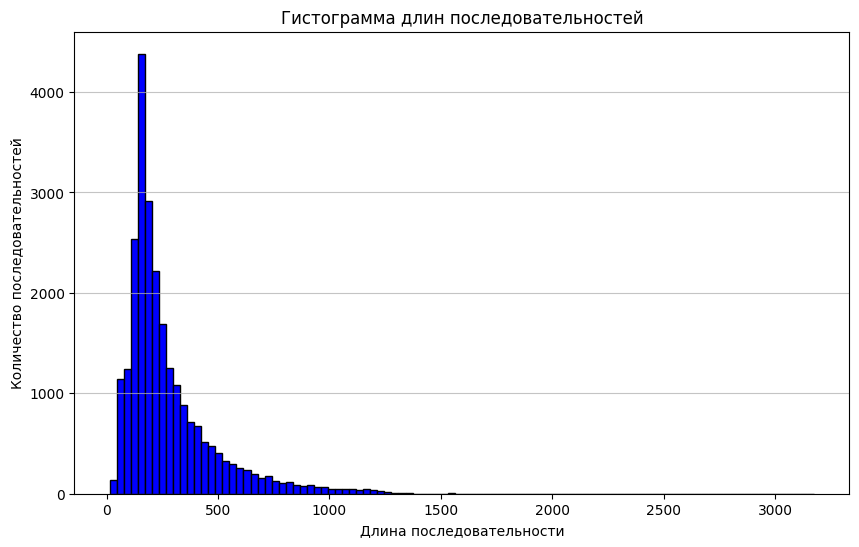

In [29]:
plotHistFromList(list_of_seq)


In [14]:
import nltk
import tqdm
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset



class CvTextDataset(Dataset):
    def __init__(
        self,
        X,
        y,
        vectorizer,
    ):
        # Далее будут те коды препроцессинга, что писали ранее
        data=pd.DataFrame({'target': y, 'text': X})
        self.target_column = 'target'

        self.vectorizer = vectorizer

        # Текстовые фичи: токенизация
        # data.fillna({k: "NaN" for k in self.text_columns}, inplace=True)
        X_ = list()
        tokenizer = nltk.tokenize.WordPunctTokenizer()
        for seq in X:
            tmp = ' '.join(tokenizer.tokenize(seq))
            X_.append(tmp)

        data['text'] = X_
        # self.pad_len_for_column = {
        #     "Text": pad_title_len
        # }

        # self.wv = wv
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        one_row = self.data.iloc[index]
        target = one_row[self.target_column]
        
        # Преобразуем текст в тензор
        text_vector = self.vectorizer.transform({'text': one_row['text']}).toarray()
        text_tensor = torch.tensor(text_vector, dtype=torch.float32).squeeze(0)
        
        # Возвращаем тензор и целевое значение
        return text_tensor, target

In [3]:

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


class SimpleNeuralNet(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        out = self.fc(x)
        return out.squeeze()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# X_train_bow = ...
# X_test_bow = ...

In [16]:
vectorizer = CountVectorizer(max_features=10000)
vectorizer.fit_transform(X_train)

train_dataset = CvTextDataset(
    X_train,
    y_train,
    vectorizer=vectorizer,
)

test_dataset = CvTextDataset(
    X_test,
    y_test,
    vectorizer=vectorizer
)

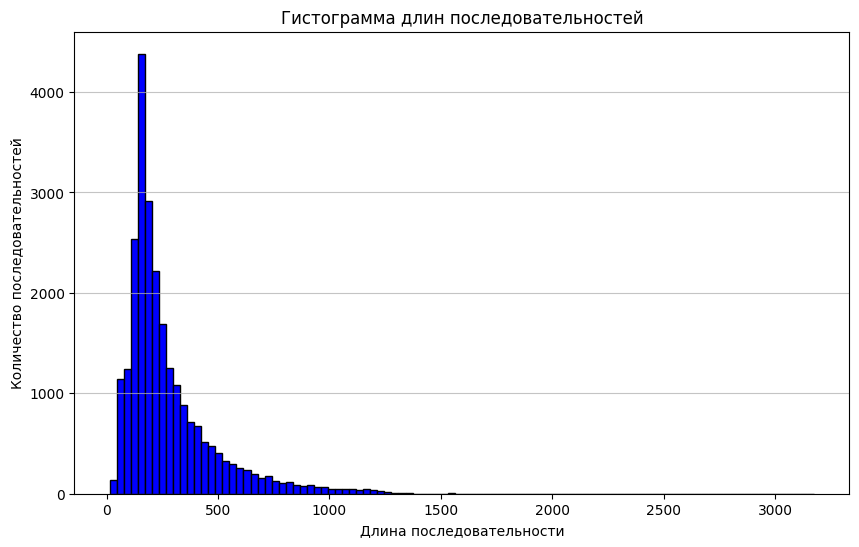

In [33]:
ll = [tokenizer.tokenize(seq) for seq in train_dataset.data['text'].to_list()]
plotHistFromList(ll)

In [48]:
len(train_dataset[0][0])


9773

In [42]:
for X, y in train_dataset:
    print(f'X.shape={X.shape}   y.shape={y.shape}')


X.shape=torch.Size([9773])   y.shape=()
X.shape=torch.Size([9773])   y.shape=()
X.shape=torch.Size([9773])   y.shape=()
X.shape=torch.Size([9773])   y.shape=()
X.shape=torch.Size([9773])   y.shape=()
X.shape=torch.Size([9773])   y.shape=()
X.shape=torch.Size([9773])   y.shape=()
X.shape=torch.Size([9773])   y.shape=()
X.shape=torch.Size([9773])   y.shape=()
X.shape=torch.Size([9773])   y.shape=()
X.shape=torch.Size([9773])   y.shape=()
X.shape=torch.Size([9773])   y.shape=()
X.shape=torch.Size([9773])   y.shape=()
X.shape=torch.Size([9773])   y.shape=()
X.shape=torch.Size([9773])   y.shape=()
X.shape=torch.Size([9773])   y.shape=()
X.shape=torch.Size([9773])   y.shape=()
X.shape=torch.Size([9773])   y.shape=()
X.shape=torch.Size([9773])   y.shape=()
X.shape=torch.Size([9773])   y.shape=()
X.shape=torch.Size([9773])   y.shape=()
X.shape=torch.Size([9773])   y.shape=()
X.shape=torch.Size([9773])   y.shape=()
X.shape=torch.Size([9773])   y.shape=()
X.shape=torch.Size([9773])   y.shape=()


In [5]:
import os
import random
import numpy as np


def enable_determinism():
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    torch.use_deterministic_algorithms(True)


def fix_seeds(seed: int):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.mps.manual_seed(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)


enable_determinism()
fix_seeds(0)

In [50]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=4,
    pin_memory=False,
    shuffle=True,
    worker_init_fn=seed_worker,
    generator=g,
)
val_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

In [51]:
import torch.nn.functional as F
import wandb
from torch.optim import Adam
TARGET_COLUMN = 'target'

loss_fn = F.l1_loss


@torch.no_grad()
def loss_on_dataset(model: nn.Module, loader: DataLoader, device: torch.device):
    model.to(device).eval()
    loss = 0
    for x, target in loader:
        x = x.to(device)
        target = target.to(device)
        pred = model(x)
        loss += loss_fn(pred, target)
    model.train()
    return (loss / len(loader)).item()


def train_loop(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
):
    optimizer = Adam(model.parameters(), lr=1e-4)
    n_epochs = 6
    model.to(device).train()
    
    for _ in range(n_epochs):
        for x, target in tqdm.tqdm(train_loader):  # Извлекаем тензор и целевое значение
            x = x.to(device)  # Перемещаем тензор на устройство (GPU/CPU)
            target = target.to(device)  # Перемещаем целевое значение на устройство
            
            pred = model(x)  # Передаем тензор в модель
            loss = loss_fn(pred, target)  # Вычисляем потери
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        print("val_loss", loss_on_dataset(model, val_loader, device))
    
    return optimizer
model = SimpleNeuralNet(len(train_dataset[0][0]))
train_loop(model, train_loader, val_loader, device)

100%|██████████| 391/391 [00:02<00:00, 140.74it/s]


val_loss 0.49999961256980896


100%|██████████| 391/391 [00:02<00:00, 167.27it/s]


val_loss 0.4999995529651642


100%|██████████| 391/391 [00:02<00:00, 166.78it/s]


val_loss 0.4999995529651642


100%|██████████| 391/391 [00:02<00:00, 167.91it/s]


val_loss 0.4999995231628418


100%|██████████| 391/391 [00:02<00:00, 164.37it/s]


val_loss 0.5


100%|██████████| 391/391 [00:02<00:00, 138.49it/s]


val_loss 0.4999997615814209


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [52]:
torch.save(model.state_dict(), "model.pt")

In [54]:
# Почистим память перед дальнейшими экспериментами
del vectorizer

## Word2Vec

Попробуем использовать более продвинутую модель для подсчета эмбеддингов.
Возьмем `word2vec` - это популярная модель для эмбеддингов, ее часто используют в качестве бейзлайна.

In [5]:
from gensim.downloader import load

word2vec = load("word2vec-google-news-300")
word2vec.similar_by_word("cat")

[('cats', 0.8099379539489746),
 ('dog', 0.760945737361908),
 ('kitten', 0.7464985251426697),
 ('feline', 0.7326234579086304),
 ('beagle', 0.7150582671165466),
 ('puppy', 0.7075453400611877),
 ('pup', 0.6934291124343872),
 ('pet', 0.6891531348228455),
 ('felines', 0.6755931973457336),
 ('chihuahua', 0.6709762215614319)]

Про word2vec часто говорят, что он дает "осмысленные" эмбеддинги.
Давайте это проверим на примере.

### Задание №3
Какое слово получается, если сделать Paris - France + Germany, и с какой косинусной близостью?

Сдайте в ЛМС слово и близость в формате `'Munich', 0.98`.

In [9]:
vParis = word2vec.get_vector('Paris')
vFrance = word2vec.get_vector('France')
vGermany = word2vec.get_vector('Germany')
vResult =vParis - vFrance + vGermany

In [10]:
word2vec.most_similar(positive=[vResult], topn=1)

[('Berlin', 0.7628204822540283)]

Можно надеяться, что если эмбеддинги будут более осмысленные, то качество модели увеличится.
Давайте проверять.

### Задание №4

Возьмите ту же модель `SimpleNeuralNet` и обучите её, взяв эмбеддинги из `word2vec`.

Вы, возможно, подумаете: `word2vec` выдает по вектору на каждое слово, а в предложении слов много.
Как с этим быть, предлагаем подумать самостоятельно.

Сдайте в ЛМС код `SimpleNeuralNet` и файл с весами модели `model.pt`.

In [11]:
import numpy as np


def pad_or_trim_to_length(
    pad_length: int, vectors: list[np.ndarray], pad_vector: np.ndarray
):
    assert pad_vector.ndim == 1
    # допаддим слева, а если превысили - обрежем с конца
    vectors = vectors[:pad_length] + [pad_vector] * max(0, pad_length - len(vectors))
    return np.stack(vectors)

def seq_to_emb(
    sentences: Collection[str], wv: KeyedVectors, pad_length: int, pad_token: str = "</s>"
):
    rv = []
    
    for sentence in sentences:
        sentence_embeddings = []
        
        for one_token in sentence.split():
            if wv.has_index_for(one_token):
                sentence_embeddings.append(wv.get_vector(one_token))
        sentence_embeddings = pad_or_trim_to_length(
            pad_length, sentence_embeddings, wv.get_vector(pad_token)
        )
        rv.append(np.stack(sentence_embeddings))
        
    return np.stack(rv)


X_train_w2v = np.stack(X_train)
X_test_w2v = np.stack(X_test)
X_train_w2v.shape 

# assert X_train_w2v.shape == (25_000, 300)
# assert X_test_w2v.shape == (25_000, 300)

(25000,)

In [12]:
X_train_w2v = seq_to_emb(X_train, word2vec, 50)

In [13]:
X_train_w2v.shape

(25000, 50, 300)

In [37]:

torch.save(model.state_dict(), "model-w2v.pt")

In [10]:
def words_to_embeddings(words, word2vec_model):
    # в список помещаются среднее значение ембеддинга по всем словам в предложении - и это среднее имеет размер 300
    embeddings = []
    for word in words:
        if word in word2vec_model.key_to_index:
            embeddings.append(word2vec_model[word])
        else:
            embeddings.append(np.zeros(word2vec_model.vector_size))

    return np.mean(embeddings, axis=0)

In [ ]:
#имеют размерность (25000, 300)  25000 - количество записей в исходной базе, 300 - размерность вектора для w2v
X_train_emb = np.array([words_to_embeddings(words, word2vec) for words in X_train])

X_test_emb = np.array([words_to_embeddings(words, word2vec) for words in X_test])

In [14]:
print(X_train_emb.shape)
print(len(X_train))
print(type(X_train_emb[0]))
print(X_train_emb[0].shape)
print(y_train.shape[0])

(25000, 300)
25000
<class 'numpy.ndarray'>
(300,)
25000


In [ ]:
class CvTextDataset(Dataset):
    def __init__(
        self,
        X,
        y,
        pad_len,
        vectorizer,
    ):
        # Далее будут те коды препроцессинга, что писали ранее
        data=pd.DataFrame({'target': y, 'text': X})
        self.target_column = 'target'
        self.text_column = 'text'
        self.vectorizer = vectorizer
        X_ = list()
        tokenizer = nltk.tokenize.WordPunctTokenizer()
        for seq in X:
            tmp = ' '.join(tokenizer.tokenize(seq)).lower()
            X_.append(tmp)
        data[self.text_column] = X_
        self.pad_len = pad_len
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index: int) -> tuple[torch.Tensor, float]:
        one_row = self.data.iloc[index]
        target = one_row[self.target_column]

        text_tensor =  torch.from_numpy(
            seq_to_emb(
                [one_row[self.text_column]],
                wv=self.vectorizer,
                pad_length=self.pad_len,
            )
        ).squeeze(0)

        return text_tensor, target

## CvTextDataset for w2v

In [25]:
class CvTextDataset(Dataset):
    def __init__(
        self,
        X,
        y,
    
    ):
        # Далее будут те коды препроцессинга, что писали ранее
        self.X = X
        self.y = y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index: int) -> tuple[torch.Tensor, float]:
        text_tensor =  torch.from_numpy(
            self.X[index]
        ).type(torch.float).squeeze(0)
        target = self.y[index]
        return text_tensor, target

In [26]:
train_dataset = CvTextDataset(
    X_train_emb,
    y_train
)

test_dataset = CvTextDataset(
    X_test_emb,
    y_test
)

In [27]:
print(len(train_dataset))
print(train_dataset[0][0])

25000
tensor([-1.3120e-01,  8.1932e-02, -2.0619e-03,  9.8006e-02, -3.4052e-02,
         1.3148e-02, -7.1037e-02, -3.6215e-02, -2.7910e-02,  1.2238e-02,
        -4.6141e-02, -5.7261e-02, -1.4278e-01,  1.9670e-02, -8.2873e-02,
         6.4584e-02,  6.2111e-02,  1.1991e-01, -1.8658e-02,  4.4915e-03,
        -1.7688e-01, -2.3952e-02,  7.1249e-02,  1.1577e-02, -6.0659e-02,
         2.5232e-02, -1.7513e-01,  4.2009e-02, -1.5066e-02, -1.1257e-02,
        -1.6382e-04,  1.6445e-02, -4.7279e-02, -6.9431e-02, -9.5145e-02,
         6.7182e-02, -1.5021e-01,  8.4653e-02, -4.2354e-02,  5.7564e-02,
        -2.5474e-02, -3.4352e-02,  4.7485e-02,  6.4987e-02,  3.4453e-02,
        -2.2360e-02, -2.8780e-02, -1.1838e-01, -7.9088e-02,  5.5564e-02,
        -1.2093e-01,  1.6547e-01, -2.3950e-02,  1.5988e-01,  3.2997e-02,
         9.3173e-02, -1.1094e-01, -6.9154e-02, -4.6640e-03, -1.1139e-01,
        -9.3718e-02, -5.2324e-02, -1.3115e-01, -3.9501e-02, -2.7397e-02,
        -1.4576e-01, -6.4171e-02,  7.9706e-02

In [28]:
batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=4,
    pin_memory=False,
    shuffle=True,
    worker_init_fn=seed_worker,
    generator=g,
)
val_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

In [52]:
import torch.nn.functional as F
# import wandb
from torch.optim import Adam
TARGET_COLUMN = 'target'

loss_fn = F.l1_loss


@torch.no_grad()
def loss_on_dataset(model: nn.Module, loader: DataLoader, device: torch.device):
    model.to(device).eval()
    loss = 0
    for x, target in loader:
        x = x.to(device)
        target = target.to(device)
        pred = model(x)
        loss += loss_fn(pred, target)
    model.train()
    return (loss / len(loader)).item()


def train_loop(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
):
    optimizer = Adam(model.parameters(), lr=1e-4)
    n_epochs = 6
    model.to(device).train()
    
    for _ in range(n_epochs):
        for x, target in tqdm.tqdm(train_loader):  # Извлекаем тензор и целевое значение
            x = x.to(device)  # Перемещаем тензор на устройство (GPU/CPU)
            target = target.to(device)  # Перемещаем целевое значение на устройство
            
            pred = model(x)  # Передаем тензор в модель
            print(f'###### target.shape={target.shape}')
            print(f'###### pred.shape={pred.shape}')
            loss = loss_fn(pred, target)  # Вычисляем потери
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        print("val_loss", loss_on_dataset(model, val_loader, device))
    
    return optimizer
model = SimpleNeuralNet(300)
train_loop(model, train_loader, val_loader, device)

  0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipykernel_4739/2711675310.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_tensor = torch.tensor(text_vector, dtype=torch.float32).squeeze(0)
/tmp/ipykernel_4739/2711675310.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_tensor = torch.tensor(text_vector, dtype=torch.float32).squeeze(0)
/tmp/ipykernel_4739/2711675310.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_tensor = torch.tensor(text_vector, dtype=torch.float32).squeeze(0)
/tmp/ipykernel_4739/2711675310.py:37:

###### target.shape=torch.Size([64])
###### pred.shape=torch.Size([64, 50])


RuntimeError: The size of tensor a (50) must match the size of tensor b (64) at non-singleton dimension 1

In [57]:
!wandb login cc603ae0565bbbfce5cc5b068a9bddabb8950920

wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [83]:
loss_fn = F.l1_loss

@torch.no_grad
def loss_on_dataset(model: nn.Module, loader: DataLoader, device: torch.device):
    model.to(device).eval()
    loss = 0
    
    for x in loader:
        x = {k: v.to(device) for k, v in x.items()}
        pred = model(x)
        loss = loss + loss_fn(pred, x[TARGET_COLUMN])
        
    model.train()
    return (loss / len(loader)).item()

def train_loop(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
):
    optimizer = Adam(model.parameters(), lr=1e-4)
    n_epochs = 6
    model.to(device).train()
    wandb.watch(model, criterion=loss_fn, log="parameters", log_freq=100)
    
    for _ in range(n_epochs):
        for x in tqdm.tqdm(train_loader):
            # x = {k: v.to(device) for k, v in x.items()}
            pred = model(x[0].to(device))
            loss = loss_fn(pred, x[1])
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            wandb.log({"loss": loss.item()})
        wandb.log({"val_loss": loss_on_dataset(model, val_loader, device)})
    return optimizer

In [84]:
wandb.init(project="start-dl--lesson-6-work")
train_loop(model, train_loader, val_loader, device)

  0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipykernel_4739/1428822338.py:31: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(pred, x[1])
  0%|          | 0/391 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (50) must match the size of tensor b (64) at non-singleton dimension 1

In [35]:
@torch.no_grad
def loss_on_dataset(model: nn.Module, loader: DataLoader, device: torch.device):
    model.to(device).eval()
    loss = 0
    
    for x, y in loader:
        x = x.to(device)  # Move input data to the correct device
        y = y.to(device)  # Move target data to the correct device
        pred = model(x)
        loss = loss + loss_fn(pred, y)
        
    model.train()
    return (loss / len(loader))

def train_loop(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
):
    optimizer = Adam(model.parameters(), lr=1e-4)
    n_epochs = 6
    model.to(device).train()
    
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        
        # Тренировочный цикл
        for x, target in tqdm.tqdm(train_loader):
            # print(f'x.shape={x.shape}')
            # print(f'target.shape={target.shape}')
            x = x.to(device)
            target = target.to(device)
            
            # Обнуляем градиенты
            optimizer.zero_grad()
            
            # Прямой проход
            pred = model(x)
            
            # Вычисление потерь
            loss = loss_fn(pred, target)
            
            # Обратное распространение и обновление параметров
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        # Вычисляем средние потери за эпоху
        avg_train_loss = total_loss / len(train_loader)
        
        # Валидационный цикл
        avg_val_loss = loss_on_dataset(model, val_loader, device)
        
        # Выводим результаты эпохи
        print(f"Epoch {epoch + 1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    print("Training complete.")

In [90]:
len(train_dataset[0][0])

50

In [36]:
model = SimpleNeuralNet(300)
train_loop(model, train_loader, val_loader, device)

100%|██████████| 391/391 [00:00<00:00, 422.70it/s]


Epoch 1/6, Train Loss: 0.5000, Val Loss: 0.4999


100%|██████████| 391/391 [00:00<00:00, 397.64it/s]


Epoch 2/6, Train Loss: 0.4999, Val Loss: 0.4999


100%|██████████| 391/391 [00:01<00:00, 383.48it/s]


Epoch 3/6, Train Loss: 0.4999, Val Loss: 0.4998


100%|██████████| 391/391 [00:00<00:00, 421.23it/s]


Epoch 4/6, Train Loss: 0.4998, Val Loss: 0.4997


100%|██████████| 391/391 [00:01<00:00, 367.55it/s]


Epoch 5/6, Train Loss: 0.4997, Val Loss: 0.4997


100%|██████████| 391/391 [00:00<00:00, 395.75it/s]


Epoch 6/6, Train Loss: 0.4996, Val Loss: 0.4996
Training complete.


In [ ]:
def words_to_embeddings(words, word2vec_model):
    embeddings = []
    for word in words:
        if word in word2vec_model.key_to_index:
            embeddings.append(word2vec_model[word])
        else:
            embeddings.append(np.zeros(word2vec_model.vector_size))

    return np.mean(embeddings, axis=0)

# Преобразование последовательностей слов в эмбеддинги

X_train_emb = np.array([words_to_embeddings(words, word2vec_model) for words in X_train])

X_test_emb = np.array([words_to_embeddings(words, word2vec_model) for words in X_test])

Возможно, качество вырастет не так сильно, но зато теперь мы можем считать эмбеддинги отдельно для каждого слова.
А это значит, что мы можем попробовать учесть порядок слов в предложении.

## TextCNN

Модель TextCNN - одна из первых попыток учесть положение слов в тексте.
Попробуем обучить эту модель.

### Задание №5

Обучите `TextCNN` на датасете IMDb, используя эмбеддинги `word2vec` и паддинг из прошлого пункта.

Не забудьте, что в таком подходе каждое предложение имеет размерность не `(300, )`, а `(n_words, 300)`.
А это значит:
- нужен паддинг;
- нужно переписать логику подсчета эмбеддингов для предложения.

Вы можете поискать подсказки в семинаре.

Сдайте в ЛМС код `TextCNN` и файл с весами модели.

In [6]:
class TextCnn(nn.Module):
    def __init__(self, word2vec_model, pad_length):
        super().__init__()
        self.word2vec_model = word2vec_model
        self.pad_length = pad_length
        emb_size = 300  # Размерность вектора word2vec
        filter_sizes = [2, 3, 4]  # Размеры фильтров для свертки
        num_filters = 2  # Количество фильтров для каждого размера

        # Создаем сверточные слои с разными размерами фильтров
        self.text_filters = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv1d(emb_size, num_filters, kernel_size=fs),
                    nn.ReLU(),
                )
                for fs in filter_sizes
            ]
        )

        # Полносвязный слой для классификации
        self.fc = nn.Linear(
            num_filters * len(filter_sizes),  # Входной размер: количество фильтров * количество размеров фильтров
            1,  # Выходной размер: 1 (бинарная классификация)
        )

    def forward(self, x):
        # x: (batch_size, pad_length, emb_size)
        x = x.permute(0, 2, 1)  # Переставляем размерности для Conv1d: (batch_size, emb_size, pad_length)

        # Применяем свертки и max-pooling
        pooled_outputs = []
        for f in self.text_filters:
            conv_output = f(x)  # Применяем свертку
            pooled = torch.max(conv_output, dim=2)[0]  # Max-pooling по временной оси
            pooled_outputs.append(pooled)

        # Объединяем результаты всех сверток
        x = torch.cat(pooled_outputs, dim=1)  # (batch_size, num_filters * len(filter_sizes))

        # Применяем полносвязный слой
        x = self.fc(x).squeeze(1)  # (batch_size,)
        return x

In [63]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, filter_sizes, num_filters, embedding_matrix):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=True)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embedding_dim)) for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        x = self.fc(x)
        return x

In [8]:
word2vec = load("word2vec-google-news-300")

In [9]:
loss_fn = F.l1_loss

@torch.no_grad()
def loss_on_dataset(model: nn.Module, loader: DataLoader, device: torch.device):
    model.to(device).eval()
    loss = 0
    for x, target in loader:
        x = x.to(device)
        target = target.to(device)
        
        pred = model(x)
        loss += loss_fn(pred, target)
    model.train()
    return loss / len(loader)

In [15]:
def train_loop(model, train_loader, test_loader, optimizer, num_epochs, device):
    # Перенос модели на устройство (GPU или CPU)
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            # Перенос данных на устройство
            texts = batch['text'].to(device)
            labels = batch['label'].to(device)
            
            optimizer.zero_grad()
            outputs = model(texts)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Test Loss: {running_loss/len(train_loader)}")
        
        # Валидация
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in test_loader:
                # Перенос данных на устройство
                texts = batch['text'].to(device)
                labels = batch['label'].to(device)
                outputs = model(texts)
                val_loss += loss_fn(outputs, labels)
        
        print(f"        Validation Loss: {val_loss/len(test_loader)}")


In [34]:
def train_loop(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    # Перенос модели на устройство (GPU или CPU)
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            # Перенос данных на устройство
            texts = batch['text'].to(device)
            labels = batch['label'].to(device)
            
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")
        
        # Валидация
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in test_loader:
                # Перенос данных на устройство
                texts = batch['text'].to(device)
                labels = batch['label'].to(device)
                outputs = model(texts)
                val_loss += criterion(outputs, labels).item()
        
        print(f"Validation Loss: {val_loss/len(test_loader)}")

In [61]:
@torch.no_grad
def evaluate_model(model: nn.Module, loader: DataLoader, device: torch.device):
    """
    Вычисляет потери и accuracy модели на данных из loader.
    """
    model.to(device).eval()
    total_loss = 0
    correct = 0
    total_samples = 0
    
    for batch in tqdm.tqdm(loader):
        x = batch['text'].to(device)
        target = batch['label'].to(device)
        x = x.to(device)
        target = target.to(device)
        
        # Прямой проход
        pred = model(x)
        
        # Вычисление потерь
        loss = loss_fn(pred, target)
        total_loss += loss.item()
        print(f'target.shape={target.shape}')
        print(target)
        print(f'pred.shape={pred.shape}')
        print(pred)
        
        _, predicted = torch.max(pred, 0)  # Получаем предсказанные классы
        
        print(f'predicted={predicted}')
        correct += (predicted == target).sum().item()  # Считаем количество правильных предсказаний
        total_samples += target.size(0)  # Общее количество примеров
    
    avg_loss = total_loss / len(loader)  # Средние потери
    accuracy = correct / total_samples  # Accuracy
    
    model.train()
    return avg_loss, accuracy


def train_loop(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer, 
    num_epochs: int, 
    device: torch.device,
):
    model.to(device).train()
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        # Тренировочный цикл
        for batch in tqdm.tqdm(train_loader):
            x = batch['text'].to(device)
            target = batch['label'].to(device)
            x = x.to(device)
            target = target.to(device)
            
            # Обнуляем градиенты
            optimizer.zero_grad()
            
            # Прямой проход
            pred = model(x)
            
            # Вычисление потерь
            loss = loss_fn(pred, target)
            
            # Обратное распространение и обновление параметров
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        # Вычисляем средние потери за эпоху
        avg_train_loss = total_loss / len(train_loader)
        
        # Валидационный цикл
        avg_val_loss, val_accuracy = evaluate_model(model, val_loader, device)
        
        # Выводим результаты эпохи
        print(
            f"Epoch {epoch + 1}/{num_epochs}, "
            f"Train Loss: {avg_train_loss:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}, "
            f"Val Accuracy: {val_accuracy:.4f}"
        )

    print("Training complete.")

In [ ]:
pad_length = 100  # Максимальная длина текста после паддинга

# Создаем датасеты
train_dataset = CvTextDataset(X_train, y_train, pad_length, word2vec)
test_dataset = CvTextDataset(X_test, y_test, pad_length, word2vec)

# Создаем DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Создаем модель
model = TextCnn(word2vec, pad_length)

# Определяем функцию потерь и оптимизатор
# criterion = nn.BCEWithLogitsLoss()  # Для бинарной классификации
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Запускаем обучение
# train_loop(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device=device)
train_loop(model, train_loader, test_loader, optimizer, num_epochs=10, device=device)

In [41]:
filter_sizes = [2, 3, 4]
num_filters = 2

class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, filter_sizes, num_filters, embedding_matrix):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=True)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embedding_dim)) for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)

    def forward(self, x):
        # print(f"Input shape: {x.shape}")
        x = self.embedding(x)
        # print(f"After embedding: {x.shape}")
        
        x = x.unsqueeze(1)  # Add channel dimension
        # print(f"After unsqueeze: {x.shape}")
        
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        # for i, tensor in enumerate(x):
        #     print(f"After conv & relu (filter {i}): {tensor.shape}")
        
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        # for i, tensor in enumerate(x):
        #     print(f"After max pooling (filter {i}): {tensor.shape}")
        
        x = torch.cat(x, 1)
        # print(f"After concatenation: {x.shape}")
        
        x = self.fc(x)
        # print(f"After fully connected: {x.shape}")
        
        return x

In [42]:
class CvTextDataset(Dataset):
    def __init__(self, X, y, pad_len, word2vec, word_to_idx):
        self.X = X
        self.y = y
        self.pad_len = pad_len
        self.word2vec = word2vec
        self.word_to_idx = word_to_idx  # Словарь для преобразования слов в индексы
        self.vector_size = word2vec.vector_size

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        text = self.X[idx]
        label = self.y[idx]
        
        # Преобразование текста в индексы слов
        indices = []
        for word in text.split():
            if word in self.word_to_idx:  # Если слово есть в словаре
                indices.append(self.word_to_idx[word])
            else:
                indices.append(0)  # Используем индекс для неизвестных слов (например, 0)
        
        # Применение паддинга или обрезки
        padded_indices = indices[:self.pad_len] + [0] * max(0, self.pad_len - len(indices))
        
        # Преобразование в тензор
        text_tensor = torch.tensor(padded_indices, dtype=torch.long)  # Используем torch.long
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        return text_tensor, label_tensor

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader

def train_loop(model, train_dataset, test_dataset, num_epochs=10, batch_size=16, learning_rate=0.001):
    # Проверка доступности CUDA
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Перенос модели на устройство (GPU или CPU)
    model = model.to(device)
    
    # Создание DataLoader для обучения и тестирования
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Определение оптимизатора и функции потерь
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for texts, labels in train_loader:
            # Перенос данных на устройство (GPU или CPU)
            texts = texts.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')
        
        # Оценка модели на тестовом наборе данных
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for texts, labels in test_loader:
                # Перенос данных на устройство (GPU или CPU)
                texts = texts.to(device)
                labels = labels.to(device)
                
                outputs = model(texts)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        print(f'Test Accuracy: {100 * correct / total}%')

In [44]:
# Создание словаря word_to_idx
word2vec = load("word2vec-google-news-300")
word_to_idx = {"<PAD>": 0, "<UNK>": 1}  # <PAD> для паддинга, <UNK> для неизвестных слов
for i, word in enumerate(word2vec.index_to_key, start=2):  # Начинаем с 2, чтобы сохранить 0 и 1 для <PAD> и <UNK>
    word_to_idx[word] = i

In [40]:
len(word_to_idx)

3000002

In [22]:
torch.cuda.empty_cache()

In [12]:
import torch
print(torch.cuda.is_available())  # Должно вернуть True
print(torch.cuda.current_device())  # Должно вернуть 0 (или другой индекс GPU)
print(torch.cuda.get_device_name(0))  # Название GPU

True
0
NVIDIA GeForce RTX 4090


In [15]:
import torch
print(torch.version.cuda)  # Версия CUDA, с которой собран PyTorch
print(torch.backends.cudnn.version())  # Версия cuDNN

12.1
8902


In [16]:
import torch

if not torch.cuda.is_available():
    print("CUDA driver is not installed.")
else:
    print("CUDA driver is installed.")

if torch.backends.cudnn.is_available():
    print("cuDNN is installed.")
else:
    print("cuDNN is not installed.")

CUDA driver is installed.
cuDNN is installed.


In [17]:
#importing the pytorch and tensorflow libraries
import torch
import tensorflow as tf
#printing the versions of tensorflow and pytorch 
print(tf.__version__)
print(torch.__version__)

2.17.1
2.2.1+cu121


In [19]:
import torch

# Check GPU Drivers and CUDA Version
def check_gpu_driver():
    if torch.cuda.is_available():
        current_device = torch.cuda.current_device()
        cuda_version = torch.version.cuda

        print(f"CUDA Version: {cuda_version}")
    else:
        print("No GPU available.")

if __name__ == "__main__":
    check_gpu_driver()

CUDA Version: 12.1


In [23]:
def check_gpu_memory():
    if torch.cuda.is_available():
        current_device = torch.cuda.current_device()
        gpu = torch.cuda.get_device_properties(current_device)
        print(f"GPU Name: {gpu.name}")
        print(f"GPU Memory Total: {gpu.total_memory / 1024**2} MB")
        print(f"GPU Memory Free: {torch.cuda.memory_allocated(current_device) / 1024**2} MB")
        print(f"GPU Memory Used: {torch.cuda.memory_reserved(current_device) / 1024**2} MB")
    else:
        print("No GPU available.")


check_gpu_memory()

GPU Name: NVIDIA GeForce RTX 4090
GPU Memory Total: 24118.0625 MB
GPU Memory Free: 13.86767578125 MB
GPU Memory Used: 34.0 MB


In [32]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [29]:
torch.autograd.set_detect_anomaly(True)

In [ ]:
vocab_size = len(word_to_idx)  # Примерный размер словаря
embedding_dim = 300  # Размерность эмбеддингов
num_classes = 2  # Количество классов
pad_len = 100  # Длина паддинга
filter_sizes = [2, 3, 4]
num_filters = 2

# Предположим, что у нас есть предобученный embedding_matrix
embedding_matrix = np.random.rand(vocab_size, embedding_dim)  # Примерный embedding_matrix

# Создание модели
model = TextCNN(vocab_size, embedding_dim, num_classes, filter_sizes, num_filters, embedding_matrix)

# Создание датасетов
train_dataset = CvTextDataset(X_train, y_train, pad_len, word2vec, word_to_idx)
test_dataset = CvTextDataset(X_test, y_test, pad_len, word2vec, word_to_idx)

# Запуск обучения с поддержкой CUDA
train_loop(model, train_dataset, test_dataset)

Using device: cuda


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### Задание №6
Поэкспериментируйте с моделью и данными, попробуйте выбить наибольшее качество.

Сдайте в ЛМС наибольший accuracy, который у вас получился.